# Kaggle Bank Marketing Campaign Prediction 

### Machine Learning Classification analysis using PyMLR

The Kaggle bank marketing competition is described at the following link: 

https://www.kaggle.com/competitions/playground-series-s5e8/overview

**Objective**: Predict whether a client will subscribe to a bank term deposit  
**Evaluation**: ROC AUC Score  
**Target**: Achieve 0.98+ AUC using advanced feature engineering and ensemble techniques

This notebook uses 11 classification methods with the following functions from the PyMLR library (https://github.com/gjpelletier/PyMLR) to perform automated 5-fold cross-validated Bayesian optimization of hyperparameters using iterative trials with optuna to maximize the cross_val_score of model accuracy:

 - **logistic_auto** - sklearn LogisticRegression
 - **xgb_auto** - XGBoost XGBClassifier
 - **svr_auto** - sklearn C-Support Vector Classification (SVC)
 - **knn_auto** - sklearn KNeighborsClassifier
 - **forest_auto** - sklearn RandomForestClassifier
 - **mlp_auto** - sklearn MLPClassifier
 - **tree_auto** - sklearn DecisionTreeClassifier
 - **ada_auto** - sklearn AdaBoostClassifier
 - **xgbmlp_auto** - Hybrid XGBoost-MLPClassifier
 - **xgbrfe_auto** - XGBoost with Recursive Feature Elimination
 - **adarfe_auto** - AdaBoost with Recursive Feature Elimination

For each function the user provides an input range of hyperparameter values to analyze, and the functions use an adaptive Bayesian approach to determine the optimum values of each hyperparameter with 5-fold CV using StratifiedKFold in the optuna objective function to maximize the cross_val_score for model f1_weighted score by iterative trials. The f1_weighted score was used instead of accuracy because it is better suited to potential imbalances in the dataset. Each method (except for xgbmlp_auto and xgbrfe_auto) also performs automated feature selection using SelectKBest, mutual_info regression, and f_regression in the optuna optimization pipeline

The hybrid XGBoost-MLPClassifier function (**xgbmlp_auto**) uses a 2-stage method in the optuna optimization pipeline as described by Li et al 2022 (https://doi.org/10.3390/forecast4010011). Stage 1 uses feature importances from XGBoost XGBClassifier to select features by tuning a hyperparameter for the threshold of feature importance that is optimized by optuna. Stage 2 uses MLPClassifier for classification using the selected features that have feature importances greater than the threshold from stage 1. 

XGBoost with Recursive Feature Elimination (**xgbrfe_auto**) is similar to the hybrid XGBoost-MLPClassifer method, except that stage 1 and 2 both use XGBClassifier.

AdaBoost with Recursive Feature Elimination (**adarfe_auto**) is similar to the hybrid XGBoost-MLPClassifer method, except that stage 1 and 2 both use AdaBoostClassifier.

Each function preprocesses X to standardize continuous features (using StandardScaler) and one-hot encode categorical features (using OneHotEncoder). The functions also provide outputs of the scaler, encoder, and selected features used for the training dataset so that the same scaler, encoder, and selected features can be used to make predictions with the test data set used for submission to the competition.

Each method is presented below showing the following three steps for each method:

1) Train the model using X_train and y_train from the data in edx_train.csv and produce output of the model skill metrics and graphics including the best accuracy cross_val_score from the k-fold CV, accuracy of the final fitted model, precision, recall, confusion matrix, and the ROC curve with AUC
2) Test predictions of the response variable using X_test from the data in edx_test.csv for submission to the Kaggle competition.
3) Interpretability analysis to show **a)** the optuna results of the optimum set of hyperparameters, the optimization history (accuracy score for each trial), relative importance of each hyperparameter on model predictions, and the contour plots of the model accuracy vs the two most important hyperparameters, and **b)** the model agnostics using either SHAP beeswarm/bar plots or Permutation Importance plots to show the relative imoprtance of the most important model features.

### PyMLR description and installation

PyMLR (https://github.com/gjpelletier/PyMLR) is a Python module designed to simplify the use of various machine learning libraries and tools for regression and classification tasks. 

Run the following code in your Python environment to install PyMLR if you have not already installed it:

In [1]:
# !pip install git+https://github.com/gjpelletier/PyMLR.git --upgrade

# Read the train and test data

In this section we will perform the following steps:

- read the train.csv and test.csv in to dataframes df_train and df_test
- check the dtypes and numbers of missing values of each column of data
- prepare X_train and y_train for use in training, and X_test for use in predicting the response variable for submission to the competition

In [2]:
# Read the train and test data downloaded from kaggle at the following link:
# https://www.kaggle.com/competitions/playground-series-s5e8/data

import pandas as pd

# read train data into dataframe train
train_path = "train.csv"
df_train = pd.read_csv(train_path)
print("Train dataset shape is {}".format(df_train.shape))

# read test data into dataframe test
test_path = "test.csv"
df_test = pd.read_csv(test_path)
print("Test dataset shape is {}".format(df_test.shape))

# read full dataset into dataframe full
orig_path = "bank-full.csv"
df_orig = pd.read_csv(orig_path, sep=';')
df_orig['y'] = df_orig['y'].map({'yes': 1, 'no': 0}).astype('int')
print("Original dataset shape is {}".format(df_orig.shape))

# concatenate data in train.csv and bank-full.csv
df_train = pd.concat([df_train, df_orig], ignore_index=True)
print("Train+Original dataset shape is {}".format(df_train.shape))

Train dataset shape is (750000, 18)
Test dataset shape is (250000, 17)
Original dataset shape is (45211, 17)
Train+Original dataset shape is (795211, 18)


In [3]:
# df_train - check dtypes and numbers of missing data of each column

from PyMLR import show_dtypes
dtypes_train = show_dtypes(df_train)

             dtype nunique isna_sum
id         float64  750000    45211
age          int64      78        0
job         object      12        0
marital     object       3        0
education   object       4        0
default     object       2        0
balance      int64    8393        0
housing     object       2        0
loan        object       2        0
contact     object       3        0
day          int64      31        0
month       object      12        0
duration     int64    1790        0
campaign     int64      52        0
pdays        int64     612        0
previous     int64      51        0
poutcome    object       4        0
y            int64       2        0


### Prepare X_train, y_train, and X_test

In [4]:
# list of candidate features for the model
candidate_features = df_train.columns.to_list()
candidate_features.remove('y')
candidate_features.remove('id')

# X_train, y_train, and X_test
X_train = df_train[candidate_features].copy()
y_train = df_train['y'].copy()
X_test = df_test[candidate_features].copy()

In [ ]:
'''
# # X_train and X_test for use with enable_categorical=True
cat_dtype_cols = [
    'age','job','marital','education','default','housing',
    'loan','contact','day','month','campaign','previous','poutcome']

# cat_dtype_cols = [
#     'job','marital','education','default','housing',
#     'loan','contact','month','poutcome']

X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
X_train_cat[cat_dtype_cols] = X_train[cat_dtype_cols].astype('category')
X_test_cat[cat_dtype_cols] = X_test[cat_dtype_cols].astype('category')
dtypes_train_cat = show_dtypes(X_train_cat)
''';

# PyMLR xgb_auto - XGBoost

Running optuna to find best parameters, could take a few minutes, please wait...
Trial 1, best cv test score so far: 0.964242 ...
Trial 2, best cv test score so far: 0.964242 ...
Trial 3, best cv test score so far: 0.964242 ...
Trial 4, best cv test score so far: 0.966620 ...
Trial 5, best cv test score so far: 0.966620 ...
Trial 6, best cv test score so far: 0.966620 ...
Trial 7, best cv test score so far: 0.966620 ...
Trial 8, best cv test score so far: 0.966620 ...
Trial 9, best cv test score so far: 0.966620 ...
Trial 10, best cv test score so far: 0.966620 ...
Trial 11, best cv test score so far: 0.966620 ...
Trial 12, best cv test score so far: 0.967564 ...
Trial 13, best cv test score so far: 0.967564 ...
Trial 14, best cv test score so far: 0.967564 ...
Trial 15, best cv test score so far: 0.967564 ...
Trial 16, best cv test score so far: 0.967564 ...
Trial 17, best cv test score so far: 0.967564 ...
Trial 18, best cv test score so far: 0.967564 ...
Trial 19, best cv test score

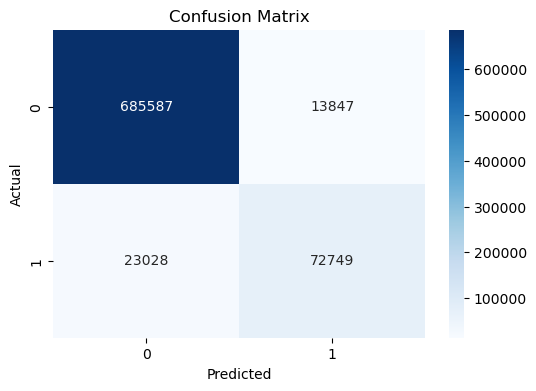

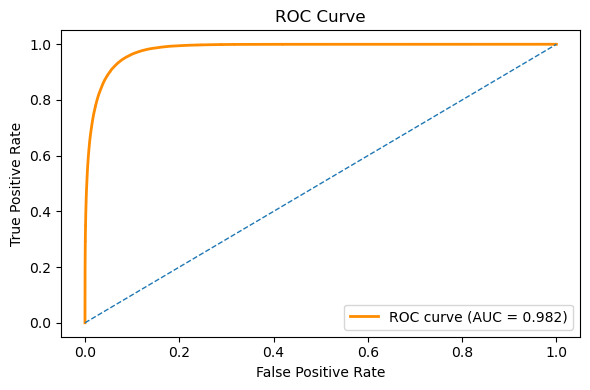

In [5]:
# 1. Train the model using X_train and y_train

kwargs = {
    'feature_selection': False,
    'scoring': "roc_auc",
    'show_trial_progress': True,
    'classify': True,               # Use XGBClassifier
    'random_state': 42,             # random seed for reproducibility
    'n_trials': 50,                 # number of optuna trials
    'learning_rate': [1e-4, 1.0],   # step size shrinkage (also called eta)
    # 'max_depth': [3, 12],           # maximum depth of a tree
    'max_depth': [3, 15],           # maximum depth of a tree
    'min_child_weight': [1, 10],    # minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.5, 1],          # fraction of samples used for training each tree
    'colsample_bytree': [0.5, 1],   # fraction of features used for each tree
    'gamma': [1e-8, 10.0],          # minimum loss reduction to make a split
    'reg_lambda': [1e-8, 10.0],     # L2 regularization term on weights
    'alpha': [1e-8, 10.0],          # L1 regularization term on weights
    # 'n_estimators': [100, 1000]     # number of boosting rounds (trees)
    'n_estimators': [100, 2000]     # number of boosting rounds (trees)
}    

from PyMLR import xgb_auto
train_model_xgb, train_output_xgb = xgb_auto(X_train, y_train, **kwargs)

In [6]:
# 2. Test predictions using X_test and submission.csv

from PyMLR import preprocess_test

preprocess_result= train_output_xgb['preprocess_result']
selected_features= train_output_xgb['selected_features']
X_test_proc = preprocess_test(X_test, preprocess_result)
model = train_model_xgb
y_pred_proba = model.predict_proba(X_test_proc[selected_features])[:, 1]

# Save your predictions as a CSV
to_save = df_test[['id']].copy()
to_save.loc[:, 'y'] = y_pred_proba
to_save.to_csv('submission_xgb_auto_v09b05.csv', index=False)

Best parameters:

learning_rate: 0.022624305900846502
max_depth: 11
min_child_weight: 2
subsample: 0.9693964399354777
colsample_bytree: 0.6324650831454071
gamma: 6.939752000503711e-06
reg_lambda: 6.67942818683005
alpha: 0.7715743974069357
n_estimators: 1775

Best score: 0.9675638614127591



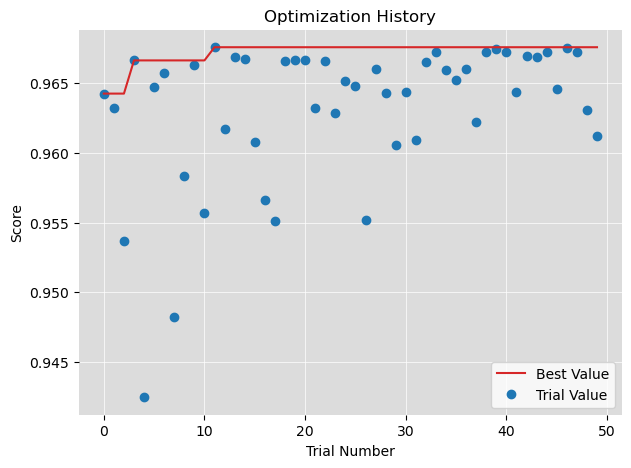

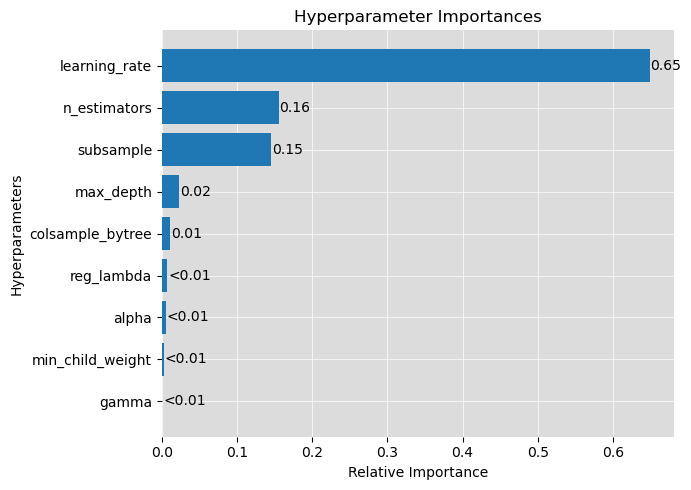

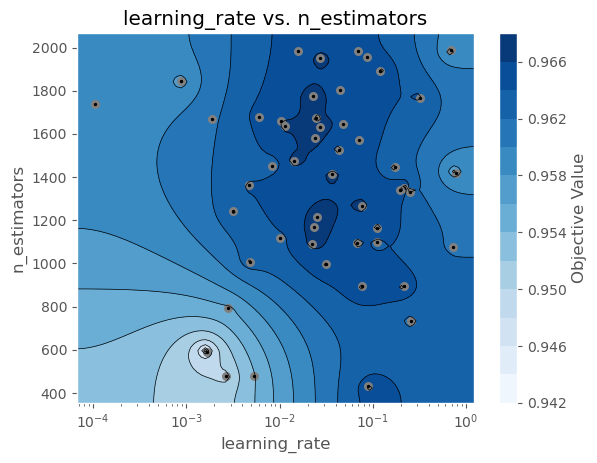

In [7]:
# 3a. Optuna results
from PyMLR import show_optuna
optuna_result_xgb = show_optuna(train_output_xgb['optuna_study'])

Performing model agnostic analysis, please wait...
Permutation Importance...


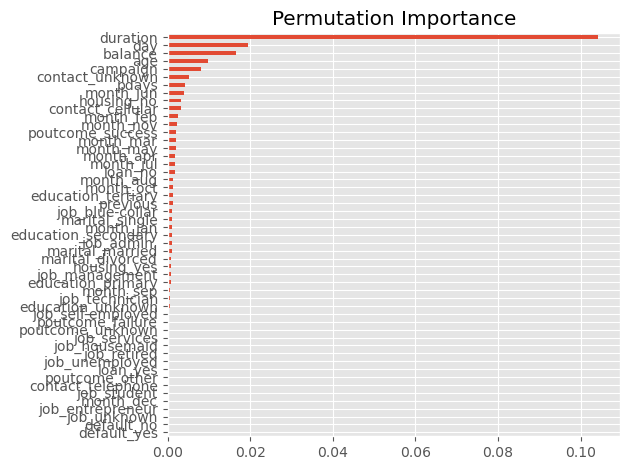

Interpretability plots saved to: model_agnostic
Done
Time elapsed: 289.94 sec



In [8]:
# 3b. Model agnostics
from PyMLR import model_agnostic
agnostic_output_xgb = model_agnostic(train_model_xgb, X_train, y_train, 
    preprocess_result= train_output_xgb['preprocess_result'],
    selected_features= train_output_xgb['selected_features'],
    output_dir= 'model_agnostic', show_perm=True)

# PyMLR xgbrfe_auto - XGBoost with Recursive Feature Elimination

Running optuna to find best parameters, could take a few minutes, please wait...
Trial 1, best cv test score so far: 0.942495 ...
Trial 2, best cv test score so far: 0.950116 ...
Trial 3, best cv test score so far: 0.963091 ...
Trial 4, best cv test score so far: 0.963091 ...
Trial 5, best cv test score so far: 0.963091 ...
Trial 6, best cv test score so far: 0.963091 ...
Trial 7, best cv test score so far: 0.963091 ...
Trial 8, best cv test score so far: 0.966281 ...
Trial 9, best cv test score so far: 0.966281 ...
Trial 10, best cv test score so far: 0.966281 ...
Trial 11, best cv test score so far: 0.966281 ...
Trial 12, best cv test score so far: 0.966281 ...
Trial 13, best cv test score so far: 0.966281 ...
Trial 14, best cv test score so far: 0.966281 ...
Trial 15, best cv test score so far: 0.966281 ...
Trial 16, best cv test score so far: 0.966281 ...
Trial 17, best cv test score so far: 0.966281 ...
Trial 18, best cv test score so far: 0.966281 ...
Trial 19, best cv test score

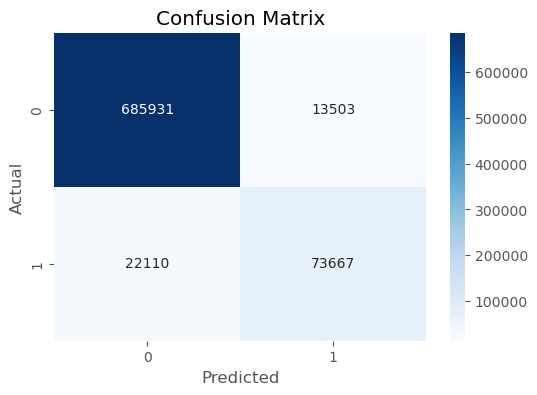

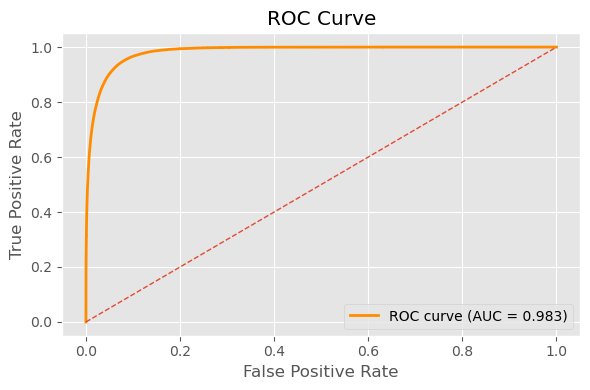

In [9]:
# 1. Train the model using X_train and y_train

kwargs = {

    'scoring': "roc_auc",
    'show_trial_progress': True,
    'classify': True,                    # True to use RandomForestClassifier
    'random_state': 42,                  # random seed for reproducibility
    'n_trials': 50,                       # number of optuna trials

    # XGBoost params for Stage 1 feature selection and Stage 2 classification
    'feature_threshold': [0.001, 0.1],   # threshold for feature_importance
    'xgb_learning_rate': [1e-4, 1.0],    # step size shrinkage (also called eta)
    'max_depth': [3, 15],                # maximum depth of a tree
    'min_child_weight': [1, 10],         # minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.5, 1],               # fraction of samples used for training each tree
    'colsample_bytree': [0.5, 1],        # fraction of features used for each tree
    'gamma': [1e-8, 10.0],               # minimum loss reduction to make a split
    'reg_lambda': [1e-8, 10.0],          # L2 regularization term on weights
    'alpha': [1e-8, 10.0],               # L1 regularization term on weights
    'n_estimators': [100, 2000],         # number of boosting rounds (trees)
    
    }
    
from PyMLR import xgbrfe_auto
train_model_xgbrfe, train_output_xgbrfe = xgbrfe_auto(X_train, y_train, **kwargs)

In [10]:
# 2. Test predictions using X_test and submission.csv

from PyMLR import preprocess_test

preprocess_result= train_output_xgbrfe['preprocess_result']
selected_features= train_output_xgbrfe['selected_features']
X_test_proc = preprocess_test(X_test, preprocess_result)
model = train_model_xgbrfe
y_pred_proba = model.predict_proba(X_test_proc[selected_features])[:, 1]

# Save your predictions as a CSV
to_save = df_test[['id']].copy()
to_save.loc[:, 'y'] = y_pred_proba
to_save.to_csv('submission_xgbrfe_auto_v09b05.csv', index=False)

Best parameters:

xgb_learning_rate: 0.03424636378558
max_depth: 14
min_child_weight: 6
subsample: 0.8115694850793136
colsample_bytree: 0.6196944863161491
gamma: 0.00018480515445962913
reg_lambda: 5.066402497620194e-07
alpha: 8.443963278276991
n_estimators: 1493
feature_threshold: 0.0013754142215573828

Best score: 0.9672363736188444



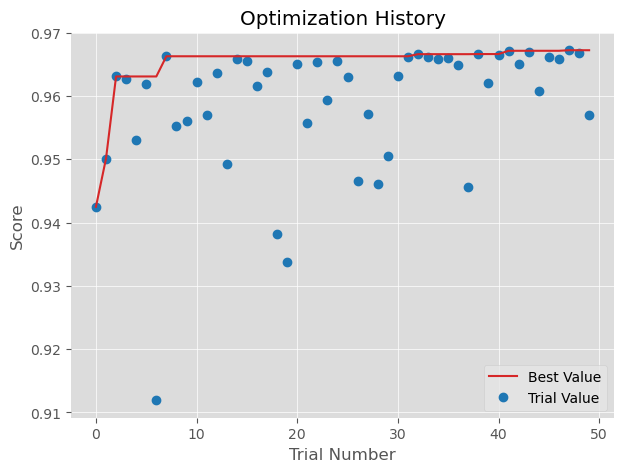

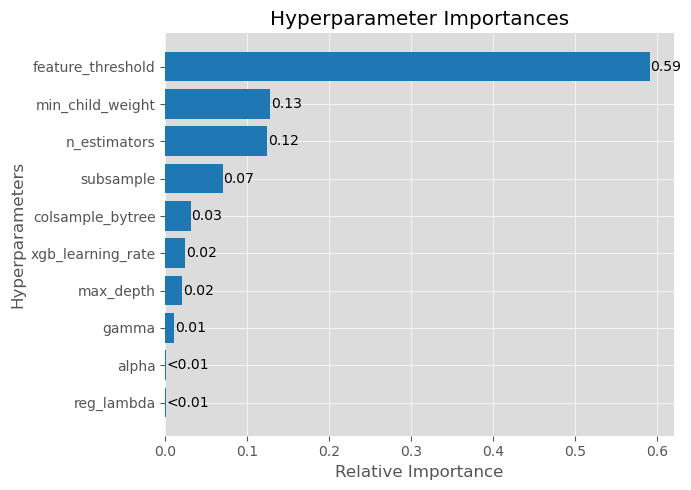

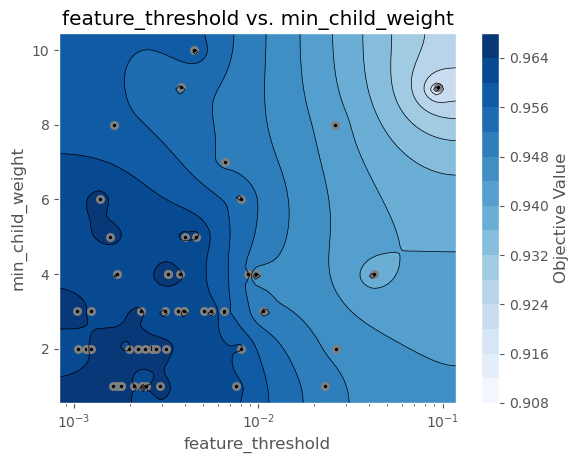

In [11]:
# 3a. Optuna results
from PyMLR import show_optuna
optuna_result_xgbrfe = show_optuna(train_output_xgbrfe['optuna_study'])

Performing model agnostic analysis, please wait...
Permutation Importance...


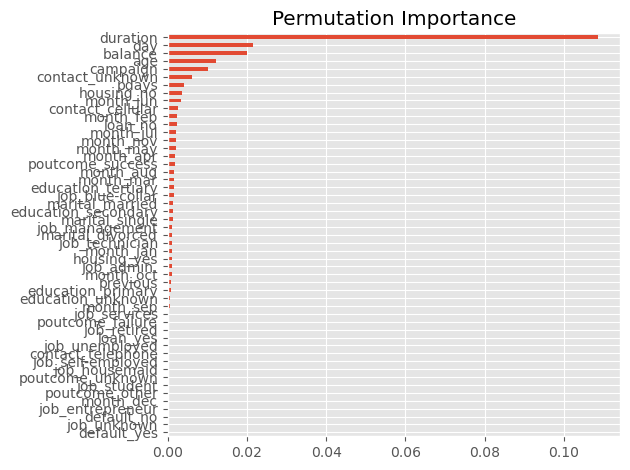

Interpretability plots saved to: model_agnostic
Done
Time elapsed: 213.94 sec



In [12]:
# 3b. Model agnostics
from PyMLR import model_agnostic
agnostic_output_xgbrfe = model_agnostic(train_model_xgbrfe, X_train, y_train, 
    preprocess_result= train_output_xgbrfe['preprocess_result'],
    selected_features= train_output_xgbrfe['selected_features'],
    output_dir= 'model_agnostic', show_perm=True)

# PyMLR xgb_auto - XGBoost with enable_categorical

In [ ]:
# # X_train and X_test for use with enable_categorical=True

cat_dtype_cols = [
    'age','job','marital','education','default','housing',
    'loan','contact','day','month','campaign','previous','poutcome']

# cat_dtype_cols = [
#     'job','marital','education','default','housing',
#     'loan','contact','month','poutcome']

X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
X_train_cat[cat_dtype_cols] = X_train[cat_dtype_cols].astype('category')
X_test_cat[cat_dtype_cols] = X_test[cat_dtype_cols].astype('category')

Running optuna to find best parameters, could take a few minutes, please wait...
Trial 1, best cv test score so far: 0.962663 ...
Trial 2, best cv test score so far: 0.962663 ...
Trial 3, best cv test score so far: 0.962663 ...
Trial 4, best cv test score so far: 0.965015 ...
Trial 5, best cv test score so far: 0.965015 ...
Trial 6, best cv test score so far: 0.965015 ...
Trial 7, best cv test score so far: 0.965946 ...
Trial 8, best cv test score so far: 0.965946 ...
Trial 9, best cv test score so far: 0.965946 ...
Trial 10, best cv test score so far: 0.965946 ...
Trial 11, best cv test score so far: 0.966253 ...
Trial 12, best cv test score so far: 0.966253 ...
Trial 13, best cv test score so far: 0.966253 ...
Trial 14, best cv test score so far: 0.966253 ...
Trial 15, best cv test score so far: 0.966253 ...
Trial 16, best cv test score so far: 0.966253 ...
Trial 17, best cv test score so far: 0.966253 ...
Trial 18, best cv test score so far: 0.966253 ...
Trial 19, best cv test score

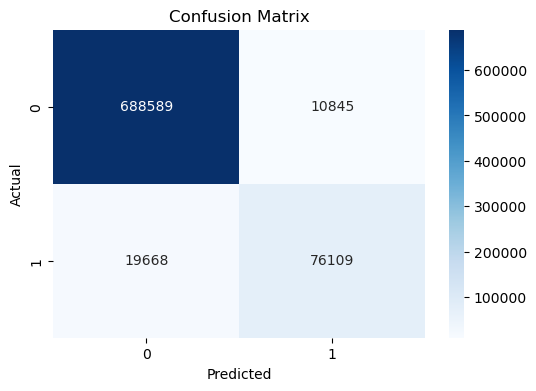

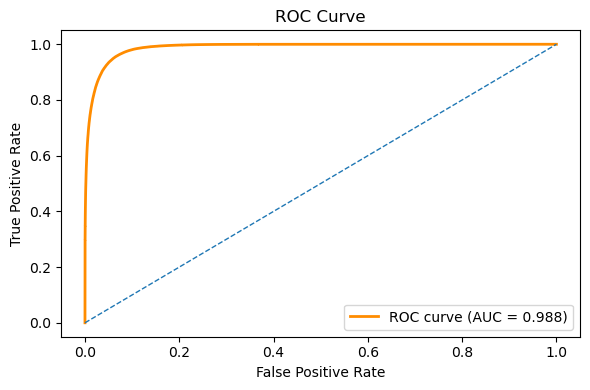

In [7]:
# 1. Train the model using X_train and y_train

kwargs = {
    'enable_categorical': True,
    'feature_selection': False,
    'scoring': "roc_auc",
    'show_trial_progress': True,
    'classify': True,               # Use XGBClassifier
    'random_state': 42,             # random seed for reproducibility
    'n_trials': 50,                 # number of optuna trials
    'learning_rate': [1e-4, 1.0],   # step size shrinkage (also called eta)
    # 'max_depth': [3, 12],           # maximum depth of a tree
    'max_depth': [3, 15],           # maximum depth of a tree
    'min_child_weight': [1, 10],    # minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.5, 1],          # fraction of samples used for training each tree
    'colsample_bytree': [0.5, 1],   # fraction of features used for each tree
    'gamma': [1e-8, 10.0],          # minimum loss reduction to make a split
    'reg_lambda': [1e-8, 10.0],     # L2 regularization term on weights
    'alpha': [1e-8, 10.0],          # L1 regularization term on weights
    # 'n_estimators': [100, 1000]     # number of boosting rounds (trees)
    'n_estimators': [100, 2000]     # number of boosting rounds (trees)
}    

from PyMLR import xgb_auto
train_model_xgbcat, train_output_xgbcat = xgb_auto(X_train_cat, y_train, **kwargs)

In [9]:
# # X_train and X_test for use with enable_categorical=True

# cat_dtype_cols = [
#     'age','job','marital','education','default','housing',
#     'loan','contact','day','month','campaign','previous','poutcome']

cat2_dtype_cols = [
    'job','marital','education','default','housing',
    'loan','contact','month','poutcome']

X_train_cat2 = X_train.copy()
X_test_cat2 = X_test.copy()
X_train_cat2[cat2_dtype_cols] = X_train[cat2_dtype_cols].astype('category')
X_test_cat2[cat2_dtype_cols] = X_test[cat2_dtype_cols].astype('category')

Running optuna to find best parameters, could take a few minutes, please wait...
Trial 1, best cv test score so far: 0.964242 ...
Trial 2, best cv test score so far: 0.964242 ...
Trial 3, best cv test score so far: 0.964242 ...
Trial 4, best cv test score so far: 0.966620 ...
Trial 5, best cv test score so far: 0.966620 ...
Trial 6, best cv test score so far: 0.966620 ...
Trial 7, best cv test score so far: 0.966620 ...
Trial 8, best cv test score so far: 0.966620 ...
Trial 9, best cv test score so far: 0.966620 ...
Trial 10, best cv test score so far: 0.966620 ...
Trial 11, best cv test score so far: 0.966620 ...
Trial 12, best cv test score so far: 0.967564 ...
Trial 13, best cv test score so far: 0.967564 ...
Trial 14, best cv test score so far: 0.967564 ...
Trial 15, best cv test score so far: 0.967564 ...
Trial 16, best cv test score so far: 0.967564 ...
Trial 17, best cv test score so far: 0.967564 ...
Trial 18, best cv test score so far: 0.967564 ...
Trial 19, best cv test score

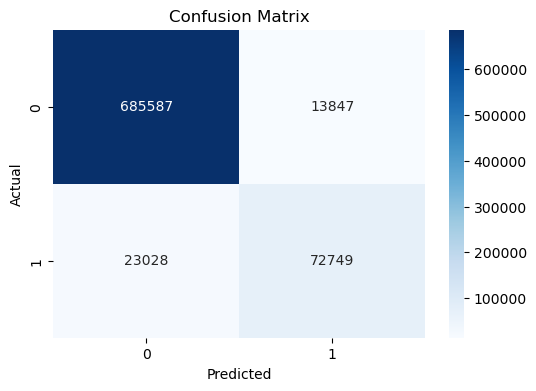

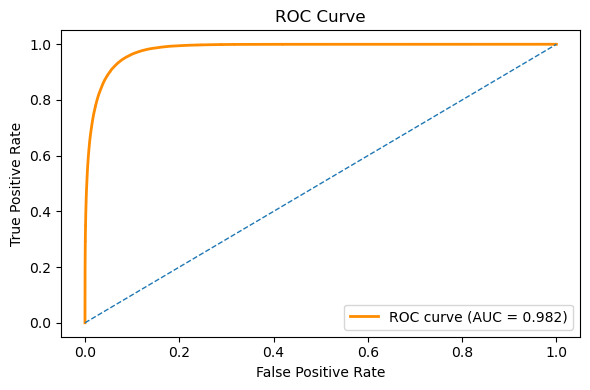

In [10]:
# 1. Train the model using X_train and y_train

kwargs = {
    'enable_categorical': True,
    'feature_selection': False,
    'scoring': "roc_auc",
    'show_trial_progress': True,
    'classify': True,               # Use XGBClassifier
    'random_state': 42,             # random seed for reproducibility
    'n_trials': 50,                 # number of optuna trials
    'learning_rate': [1e-4, 1.0],   # step size shrinkage (also called eta)
    # 'max_depth': [3, 12],           # maximum depth of a tree
    'max_depth': [3, 15],           # maximum depth of a tree
    'min_child_weight': [1, 10],    # minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.5, 1],          # fraction of samples used for training each tree
    'colsample_bytree': [0.5, 1],   # fraction of features used for each tree
    'gamma': [1e-8, 10.0],          # minimum loss reduction to make a split
    'reg_lambda': [1e-8, 10.0],     # L2 regularization term on weights
    'alpha': [1e-8, 10.0],          # L1 regularization term on weights
    # 'n_estimators': [100, 1000]     # number of boosting rounds (trees)
    'n_estimators': [100, 2000]     # number of boosting rounds (trees)
}    

from PyMLR import xgb_auto
train_model_xgbcat2, train_output_xgbcat2 = xgb_auto(X_train_cat2, y_train, **kwargs)

In [11]:
# 2. Test predictions using X_test and submission.csv

from PyMLR import preprocess_test

preprocess_result= train_output_xgbcat2['preprocess_result']
selected_features= train_output_xgbcat2['selected_features']
X_test_proc = preprocess_test(X_test_cat2, preprocess_result)
model = train_model_xgbcat2
y_pred_proba = model.predict_proba(X_test_proc[selected_features])[:, 1]

# Save your predictions as a CSV
to_save = df_test[['id']].copy()
to_save.loc[:, 'y'] = y_pred_proba
to_save.to_csv('submission_xgbcat2_auto_v09b05.csv', index=False)

Best parameters:

learning_rate: 0.022624305900846502
max_depth: 11
min_child_weight: 2
subsample: 0.9693964399354777
colsample_bytree: 0.6324650831454071
gamma: 6.939752000503711e-06
reg_lambda: 6.67942818683005
alpha: 0.7715743974069357
n_estimators: 1775

Best score: 0.9675638614127591



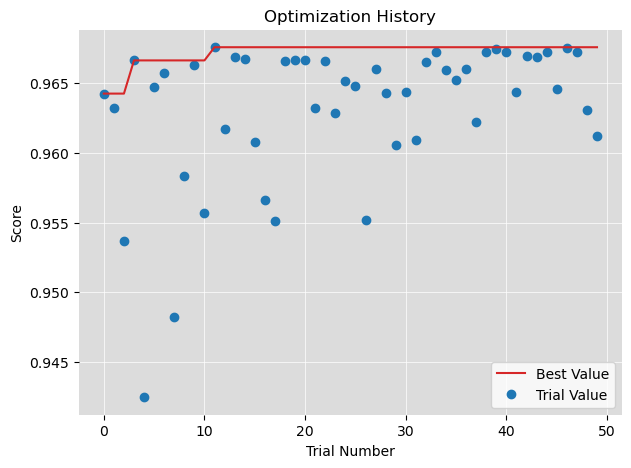

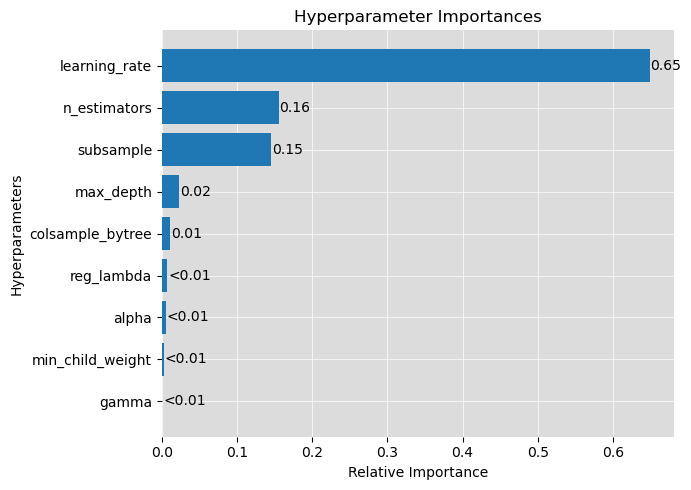

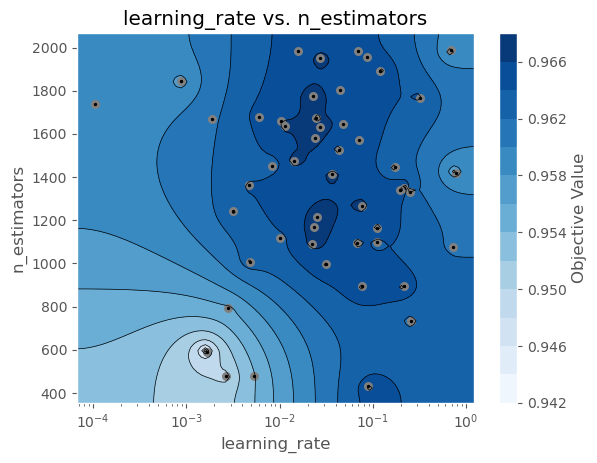

In [12]:
# 3a. Optuna results
from PyMLR import show_optuna
optuna_result_xgbcat2 = show_optuna(train_output_xgbcat2['optuna_study'])

Performing model agnostic analysis, please wait...
Permutation Importance...


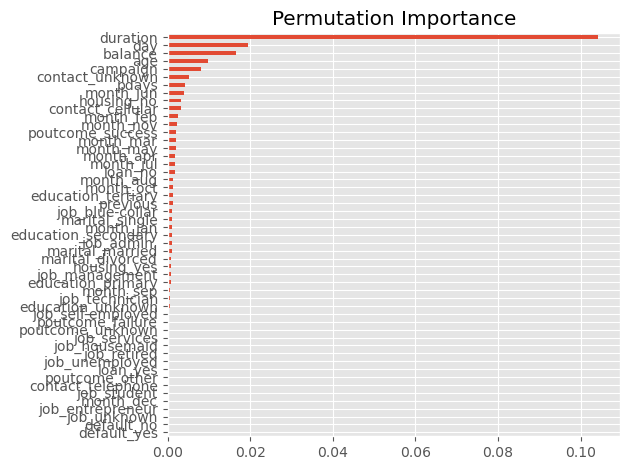

Interpretability plots saved to: model_agnostic
Done
Time elapsed: 239.33 sec



In [13]:
# 3b. Model agnostics
from PyMLR import model_agnostic
agnostic_output_xgbcat2 = model_agnostic(train_model_xgbcat2, X_train, y_train, 
    preprocess_result= train_output_xgbcat2['preprocess_result'],
    selected_features= train_output_xgbcat2['selected_features'],
    output_dir= 'model_agnostic', show_perm=True)

# PyMLR xgb_auto - XGBoost with interaction features

### Pairwise interaction feature engineering

In this section we will do the following steps for feature engineering:

1) Create copies X_train2 and X_test2 to contain the new engineered interaction features
2) Identify which columns are categorical using a threshold of 12 unique itmes, and make lists of column names that are categorical and numerical
3) Change the categorical columns to dtype categorical for use with XGBoost enable_categorical
4) Identify all possible pairwise combinations of categorical and numeric columns
5) Add new numeric columns for pairwise interaction products of numeric columns
6) Add new categorical columns for pairwise interaction combinations of categorical columns 

In [5]:
import numpy as np
import pandas as pd
from itertools import combinations

'''
def add_features_step1(df):
    df = df.copy()
    df["arcsinh_balance"] = np.arcsinh(df["balance"])
    df["arcsinh_duration"] = np.arcsinh(df["duration"])
    df["day_sin"] = np.sin(2 * np.pi * df["day"] / 31)
    df["day_cos"] = np.cos(2 * np.pi * df["day"] / 31)    
    return df

def add_features_step2(df):
    df = df.copy()
    month_map = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
                 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
    month_num = df["month"].map(month_map).astype("int64")    
    df["month_sin"] = np.sin(2 * np.pi * month_num / 12)
    df["month_cos"] = np.cos(2 * np.pi * month_num / 12)
    return df
'''

# 1) make a copy of X_test and X_train to include the new features
X_train2 = X_train.copy()
X_test2 = X_test.copy()

'''
# 2) add features step1 before assigning categorical
X_train2 = add_features_step1(X_train2)
X_test2 = add_features_step1(X_test2)
'''

# 2) make list of column names for categorical (cat_cols) and numeric (non_cat_cols)
threshold_cat = 12
cat_cols = [col for col in X_train2.columns if X_train2[col].nunique() <= threshold_cat]
num_cols = X_train2.select_dtypes(include=[np.number]).columns.tolist()
non_cat_num_cols = [col for col in num_cols if col not in cat_cols]

# 3) use dtype category for categorical columns for XGBoost enable_categorical
X_train2[cat_cols] = X_train2[cat_cols].astype('category')
X_test2[cat_cols] = X_test2[cat_cols].astype('category')

'''
# 5) add sin cos month as numerical features after assigning categorical
# X_train2 = add_features_step2(X_train2)
# X_test2 = add_features_step2(X_test2)
'''

# 4) identify all possible pairwise combinations of categorical and numeric columns
pairwise_cats = combinations(cat_cols, 2)
pairwise_nums = combinations(non_cat_num_cols, 2)

# 5) add new columns for pairwise interaction products of non_cat_num_cols
for col1, col2 in pairwise_nums:
    new_col_name = f'{col1}_x_{col2}'
    X_train2[new_col_name] = X_train2[col1].astype('float') * X_train2[col2].astype('float')
    X_test2[new_col_name] = X_test2[col1].astype('float') * X_test2[col2].astype('float')

# 6) add new columns for pairwise interaction combinations of cat_cols
for col1, col2 in pairwise_cats:
    new_col_name = f'{col1}_x_{col2}'
    X_train2[new_col_name] = X_train2[col1].astype('object') + ' ' + X_train2[col2].astype('object')
    X_test2[new_col_name] = X_test2[col1].astype('object') + ' ' + X_test2[col2].astype('object')
    X_train2[new_col_name] = X_train2[new_col_name].astype('category')
    X_test2[new_col_name] = X_test2[new_col_name].astype('category')

# show the dtypes of X_train2 with the added pairwise interaction columns
dtypes_X_train2 = show_dtypes(X_train2)

                         dtype nunique isna_sum
age                      int64      78        0
job                   category      12        0
marital               category       3        0
education             category       4        0
default               category       2        0
balance                  int64    8393        0
housing               category       2        0
loan                  category       2        0
contact               category       3        0
day                      int64      31        0
month                 category      12        0
duration                 int64    1790        0
campaign                 int64      52        0
pdays                    int64     612        0
previous                 int64      51        0
poutcome              category       4        0
age_x_balance          float64   93496        0
age_x_day              float64    1113        0
age_x_duration         float64   27597        0
age_x_campaign         float64     933  

Running optuna to find best parameters, could take a few minutes, please wait...
Trial 1, best cv test score so far: 0.964312 ...
Trial 2, best cv test score so far: 0.964312 ...
Trial 3, best cv test score so far: 0.964312 ...
Trial 4, best cv test score so far: 0.965926 ...
Trial 5, best cv test score so far: 0.965926 ...
Trial 6, best cv test score so far: 0.965926 ...
Trial 7, best cv test score so far: 0.965926 ...
Trial 8, best cv test score so far: 0.965926 ...
Trial 9, best cv test score so far: 0.965926 ...
Trial 10, best cv test score so far: 0.965926 ...
Trial 11, best cv test score so far: 0.965926 ...
Trial 12, best cv test score so far: 0.965926 ...
Trial 13, best cv test score so far: 0.965926 ...
Trial 14, best cv test score so far: 0.965926 ...
Trial 15, best cv test score so far: 0.965926 ...
Trial 16, best cv test score so far: 0.965926 ...
Trial 17, best cv test score so far: 0.965926 ...
Trial 18, best cv test score so far: 0.965926 ...
Trial 19, best cv test score

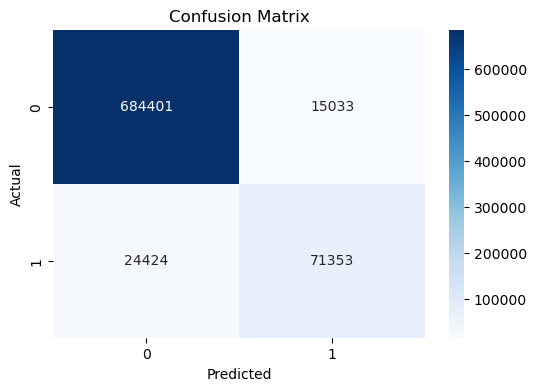

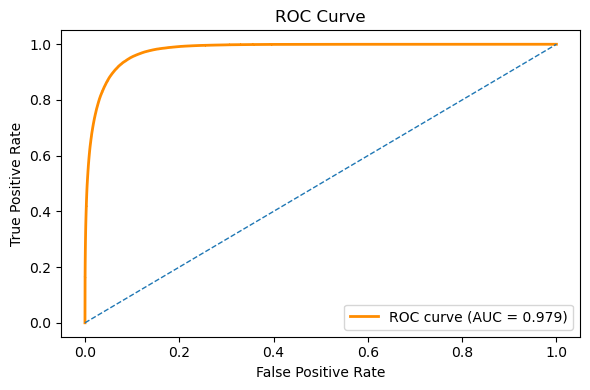

In [6]:
# 1. Train the model using X_train and y_train

kwargs = {
    'enable_categorical': True,
    'preprocess': True,
    'feature_selection': False,
    'scoring': "roc_auc",
    'show_trial_progress': True,
    'classify': True,               # Use XGBClassifier
    'random_state': 42,             # random seed for reproducibility
    'n_trials': 50,                 # number of optuna trials
    'learning_rate': [1e-4, 1.0],   # step size shrinkage (also called eta)
    'max_depth': [3, 15],           # maximum depth of a tree
    'min_child_weight': [1, 10],    # minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.5, 1],          # fraction of samples used for training each tree
    'colsample_bytree': [0.5, 1],   # fraction of features used for each tree
    'gamma': [1e-8, 10.0],          # minimum loss reduction to make a split
    'reg_lambda': [1e-8, 10.0],     # L2 regularization term on weights
    'alpha': [1e-8, 10.0],          # L1 regularization term on weights
    'n_estimators': [100, 2000]     # number of boosting rounds (trees)
}    

from PyMLR import xgb_auto
train_model_xgb2, train_output_xgb2 = xgb_auto(X_train2, y_train, **kwargs)

In [7]:
# 2. Test predictions using X_test and submission.csv

from PyMLR import preprocess_test

preprocess_result= train_output_xgb2['preprocess_result']
selected_features= train_output_xgb2['selected_features']
X_test_proc = preprocess_test(X_test2, preprocess_result)
model = train_model_xgb2
y_pred_proba = model.predict_proba(X_test_proc[selected_features])[:, 1]

# Save your predictions as a CSV
to_save = df_test[['id']].copy()
to_save.loc[:, 'y'] = y_pred_proba
to_save.to_csv('submission_xgb2_auto_v09b05.csv', index=False)

Best parameters:

learning_rate: 0.011400863701127324
max_depth: 10
min_child_weight: 1
subsample: 0.8037724259507192
colsample_bytree: 0.5852620618436457
gamma: 3.850031979199519e-08
reg_lambda: 3.4671276804481113
alpha: 4.905556676028774
n_estimators: 1636

Best score: 0.965925946724345



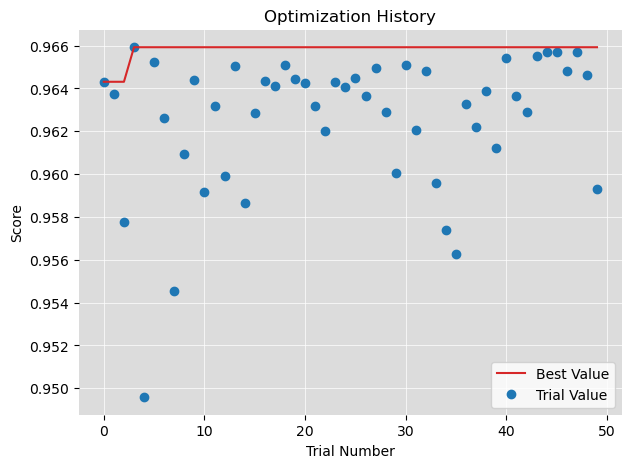

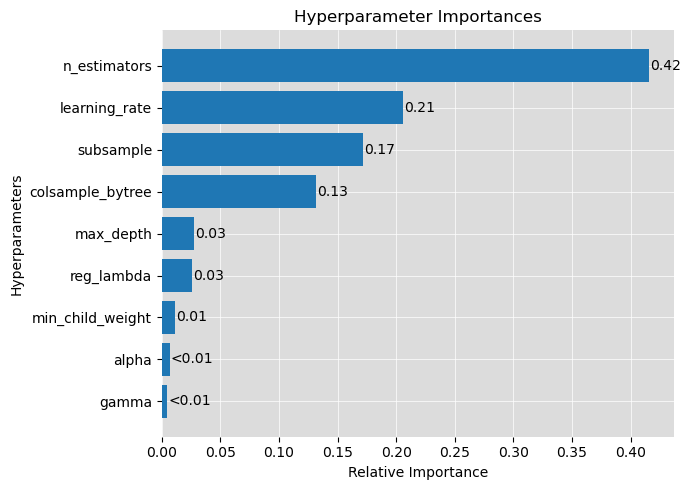

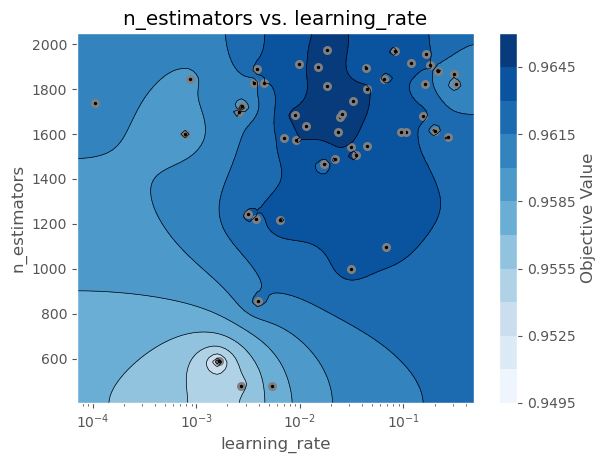

In [8]:
# 3a. Optuna results
from PyMLR import show_optuna
optuna_result_xgb2 = show_optuna(train_output_xgb2['optuna_study'])

Performing model agnostic analysis, please wait...
Permutation Importance...


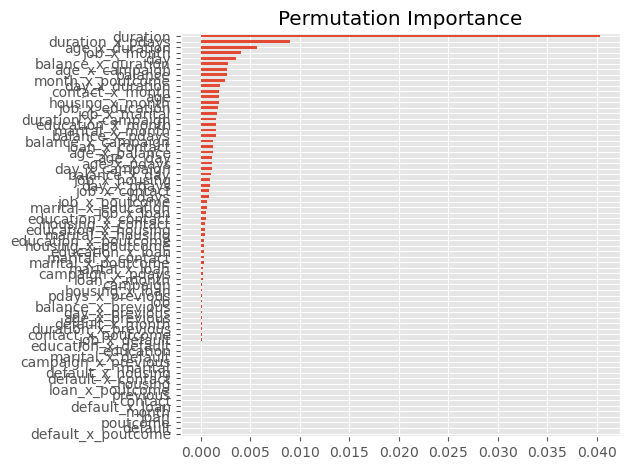

Interpretability plots saved to: model_agnostic
Done
Time elapsed: 1031.11 sec



In [9]:
# 3b. Model agnostics
from PyMLR import model_agnostic
agnostic_output_xgb2 = model_agnostic(train_model_xgb2, X_train2, y_train, 
    preprocess_result= train_output_xgb2['preprocess_result'],
    selected_features= train_output_xgb2['selected_features'],
    output_dir= 'model_agnostic', show_perm=True)

# PyMLR catboost_auto - CatBoost

In [ ]:
# 1. Train the model using X_train and y_train

kwargs = {

    'feature_selection': False,
    'scoring': "roc_auc",
    'show_trial_progress': True,
    'classify': True,               # Use XGBClassifier
    'random_state': 42,                 # random seed for reproducibility
    'n_trials': 50,                     # number of optuna trials
    'learning_rate': [0.01, 0.3],       # Balances step size in gradient updates.
    'depth': [4, 10],                   # Controls tree depth
    'iterations': [100, 3000],          # Number of boosting iterations
    'l2_leaf_reg': [1, 10],             # Regularization strength       
    'random_strength': [0, 1],          # Adds noise for diversity
    'bagging_temperature': [0.1, 1.0],  # Controls randomness in sampling
    'border_count': [32, 255],          # Number of bins for feature discretization
    'min_data_in_leaf': [1, 100],       # Minimum samples per leaf         
    'max_bin': [64, 255],               # Number of bins for feature quantization

}    

from PyMLR import catboost_auto
train_model_cat, train_output_cat = catboost_auto(X_train, y_train, **kwargs)

In [ ]:
# 2. Test predictions using X_test and submission.csv

from PyMLR import preprocess_test

preprocess_result= train_output_cat['preprocess_result']
selected_features= train_output_cat['selected_features']
X_test_proc = preprocess_test(X_test, preprocess_result)
model = train_model_cat
y_pred_proba = model.predict_proba(X_test_proc[selected_features])[:, 1]

# Save your predictions as a CSV
to_save = df_test[['id']].copy()
to_save.loc[:, 'y'] = y_pred_proba
to_save.to_csv('submission_cat_auto_v09b04.csv', index=False)

In [ ]:
# 3a. Optuna results
from PyMLR import show_optuna
optuna_result_cat = show_optuna(train_output_cat['optuna_study'])

In [ ]:
# 3b. Model agnostics
from PyMLR import model_agnostic
agnostic_output_cat = model_agnostic(train_model_cat, X_train, y_train, 
    preprocess_result= train_output_cat['preprocess_result'],
    selected_features= train_output_cat['selected_features'],
    output_dir= 'model_agnostic', show_perm=True)

# PyMLR ada_auto - AdaBoost

In [ ]:
# 1. Train the model using X_train and y_train

kwargs = {

    'feature_selection': False,
    'scoring': "roc_auc",
    'show_trial_progress': True,
    'classify': True,               # Use XGBClassifier
    'random_state': 42,             # random seed for reproducibility
    'n_trials': 50,                  # number of optuna trials

    # params for AdaBoost optimized by optuna
    'n_estimators': [50, 500],
    'learning_rate': [0.01, 1.0],
    'max_depth': [2, 30],           # max depth of a tree
    
    # params for base_estimator (DecisionTree) optimized by optuna
    'min_samples_split': [2, 20],   # min samples to split internal node
    'min_samples_leaf': [1, 20],    # min samples to be at a leaf node
    'max_leaf_nodes': [10, 100],    # max number of leaf nodes
    'max_features': [0.1, 1.0],     # number of features to consider 
                                    # when looking for the best split
    }
    
from PyMLR import ada_auto
train_model_ada, train_output_ada = ada_auto(X_train, y_train, **kwargs)

In [ ]:
# 2. Test predictions using X_test and submission.csv

from PyMLR import preprocess_test

preprocess_result= train_output_ada['preprocess_result']
selected_features= train_output_ada['selected_features']
X_test_proc = preprocess_test(X_test, preprocess_result)
model = train_model_ada
y_pred_proba = model.predict_proba(X_test_proc[selected_features])[:, 1]

# Save your predictions as a CSV
to_save = df_test[['id']].copy()
to_save.loc[:, 'y'] = y_pred_proba
to_save.to_csv('submission_ada_auto_v09b02.csv', index=False)

In [ ]:
# 3a. Optuna results
from PyMLR import show_optuna
optuna_result_ada = show_optuna(train_output_ada['optuna_study'])

In [ ]:
# 3b. Model agnostics
from PyMLR import model_agnostic
agnostic_output_ada = model_agnostic(train_model_ada, X_train, y_train, 
    preprocess_result= train_output_ada['preprocess_result'],
    selected_features= train_output_ada['selected_features'],
    output_dir= 'model_agnostic', show_perm=True)

# PyMLR xgbmlp_auto - Hybrid XGBoost-MLP

In [ ]:
# 1. Train the model using X_train and y_train

# optional keyword arguments
kwargs = {

    'scoring': 'roc_auc',
    'show_trial_progress': True,
    'classify': True,                    # True to use RandomForestClassifier
    'random_state': 42,                  # random seed for reproducibility
    'n_trials': 10,                       # number of optuna trials

    # Stage 1 XGBoost params for feature selection
    'feature_threshold': [0.001, 0.1],   # threshold for feature_importance
    'xgb_learning_rate': [1e-4, 1.0],    # step size shrinkage (also called eta)
    'max_depth': [3, 12],                # maximum depth of a tree
    'min_child_weight': [1, 10],         # minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.5, 1],               # fraction of samples used for training each tree
    'colsample_bytree': [0.5, 1],        # fraction of features used for each tree
    'gamma': [1e-8, 10.0],               # minimum loss reduction to make a split
    'reg_lambda': [1e-8, 10.0],          # L2 regularization term on weights
    'alpha': [1e-8, 10.0],               # L1 regularization term on weights
    'n_estimators': [50, 500],         # number of boosting rounds (trees)
    
    # Stage 2 MLP numerical core hyperparameters 
    'n_layers': [1, 3],                  # used to determine hiden_layer_sizes depth
    'units': [10, 200],                  # used to determine hiden_layer_sizes width
    'alpha': [1e-6, 1e-1],               # L2 regularization term
    'learning_rate_init': [1e-5, 1e-1],  # initial learning rate

    # Stage 2 MLP numerical solver-specific hyperparameters 
    'batch_size': [32, 1024],            # batch size for stochastic optimizers
    'momentum': [0.5, 0.99],             # for gradient descent update
    'power_t': [0.1, 0.9],               # L2 regularization term
    'beta_1': [0.8, 0.99],               # decay for first moment adam
    'beta_2': [0.9, 0.9999],             # decay rate for second moment adam
    'epsilon': [1e-8, 1e-4],             # numerical stability in adam
    'max_fun': [15000, 50000],           # used for solver lbfgs max number function calls

    # Stage 2 MLP categorical hyperparameters 
    'activation': ["relu", "tanh", "logistic"],  # hidden layer activation method
    'solver': ["adam", "sgd", "lbfgs"],          # for weight optimization
    'mlp_learning_rate': ["constant", "invscaling", "adaptive"],  # for weight updates
    'early_stopping': [True, False],     # terminate when score not improving
    'nesterov': [True, False],           # used for nesterovs_momentum if solver is sgd
    }
    
from PyMLR import xgbmlp_auto
train_model_xgbmlp, train_output_xgbmlp = xgbmlp_auto(X_train, y_train, **kwargs)

Running optuna to find best parameters, could take a few minutes, please wait...


In [ ]:
# 2. Test predictions using X_test and submission.csv

from PyMLR import preprocess_test

preprocess_result= train_output_xgbmlp['preprocess_result']
selected_features= train_output_xgbmlp['selected_features']
X_test_proc = preprocess_test(X_test, preprocess_result)
model = train_model_xgbmlp
predictions = model.predict(X_test_proc[selected_features])

# Save your predictions as a CSV
to_save = df_test[['id']].copy()
to_save.loc[:, 'y'] = predictions
to_save.to_csv('submission_xgbmlp_auto_v10.csv', index=False)

In [ ]:
# 3a. Optuna results
from PyMLR import show_optuna
optuna_result_xgbmlp = show_optuna(train_output_xgbmlp['optuna_study'])

In [ ]:
# 3b. Model agnostics
from PyMLR import model_agnostic
agnostic_output_xgbmlp = model_agnostic(train_model_xgbmlp, X_train, y_train, 
    preprocess_result= train_output_xgbmlp['preprocess_result'],
    selected_features= train_output_xgbmlp['selected_features'],
    output_dir= 'model_agnostic', show_perm=True)

# PyMLR adarfe_auto - AdaBoost with Recursive Feature Elimination

Running optuna to find best parameters, could take a few minutes, please wait...
Trial 1, best cv test score so far: 0.914310 ...
Trial 2, best cv test score so far: 0.951234 ...
Trial 3, best cv test score so far: 0.957673 ...
Trial 4, best cv test score so far: 0.960463 ...
Trial 5, best cv test score so far: 0.960463 ...
Trial 6, best cv test score so far: 0.960463 ...
Trial 7, best cv test score so far: 0.960463 ...
Trial 8, best cv test score so far: 0.960463 ...
Trial 9, best cv test score so far: 0.960463 ...
Trial 10, best cv test score so far: 0.960463 ...
Trial 11, best cv test score so far: 0.961930 ...
Trial 12, best cv test score so far: 0.963142 ...
Trial 13, best cv test score so far: 0.963142 ...
Trial 14, best cv test score so far: 0.963719 ...
Fitting AdaBoostClassifier model with best parameters, please wait ...

AdaBoostClassifier goodness of fit to training data in model_outputs['stats']:

| Statistic          |   AdaBoostClassifier |
|:-------------------|--------

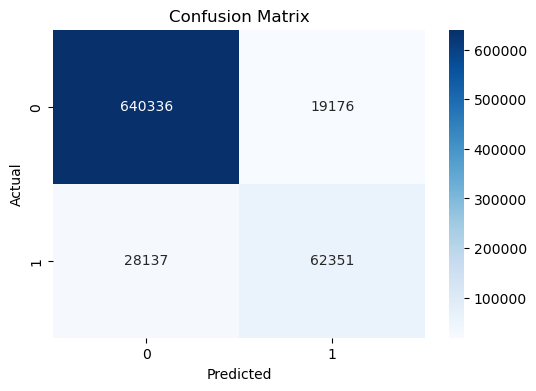

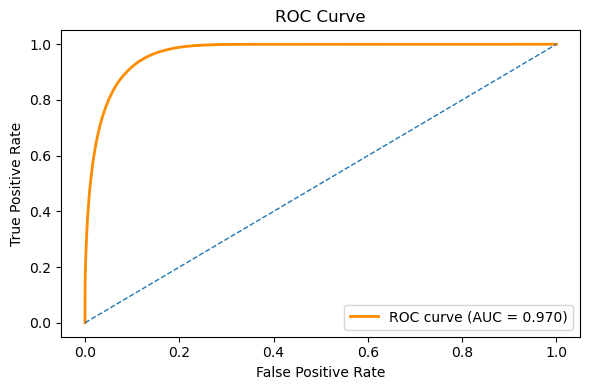

In [6]:
# 1. Train the model using X_train and y_train

kwargs = {

    'scoring': 'roc_auc',
    'show_trial_progress': True,
    'use_permutation': False,
    'classify': True,               # True to use RandomForestClassifier
    'random_state': 42,             # random seed for reproducibility
    'n_trials': 15,                  # number of optuna trials

    # params for AdaBoost optimized by optuna
    'n_estimators': [50, 500],
    'learning_rate': [0.01, 1.0],
    'max_depth': [2, 30],           # max depth of a tree
    
    # params for base_estimator (DecisionTree) optimized by optuna
    'min_samples_split': [2, 20],   # min samples to split internal node
    'min_samples_leaf': [1, 20],    # min samples to be at a leaf node
    'max_leaf_nodes': [10, 100],    # max number of leaf nodes
    'max_features': [0.1, 1.0],     # number of features to consider 
                                    # when looking for the best split
    }
    
from PyMLR import adarfe_auto
train_model_adarfe, train_output_adarfe = adarfe_auto(X_train, y_train, **kwargs)

In [11]:
# 2. Test predictions using X_test and submission.csv

from PyMLR import preprocess_test

preprocess_result= train_output_adarfe['preprocess_result']
selected_features= train_output_adarfe['selected_features']
X_test_proc = preprocess_test(X_test, preprocess_result)
model = train_model_adarfe
predictions = model.predict(X_test_proc[selected_features])

# Save your predictions as a CSV
to_save = df_test[['id']].copy()
to_save.loc[:, 'y'] = predictions
to_save.to_csv('submission_adarfe_ntrials15_2.csv', index=False)

In [ ]:
# 3a. Optuna results
from PyMLR import show_optuna
optuna_result_adarfe = show_optuna(train_output_xgbmlp['optuna_study'])

In [ ]:
# 3b. Model agnostics
from PyMLR import model_agnostic
agnostic_output_adarfe = model_agnostic(train_model_adarfe, X_train, y_train, 
    preprocess_result= train_output_adarfe['preprocess_result'],
    selected_features= train_output_adarfe['selected_features'],
    output_dir= 'model_agnostic', show_perm=True)